In [1]:
## Import packets

import logging
import numpy as np
import matplotlib.pyplot as plt
import jittor as jt
from jittor import nn
from jittor import transform
import jittor.models as models
import jittor.optim as optim
import jittor.nn as F
import pygmtools as pygm
from pygmtools.linear_solvers import sinkhorn
import os
import time
import sklearn.model_selection


pygm.BACKEND = 'jittor'
# jt.flags.lazy_execution=0
if jt.has_cuda:
    jt.flags.use_cuda = 1

logging.basicConfig(filename='output2.log', level=logging.INFO)
logging.info(f"\n\n----------{time.asctime()}----------")

from split import *
from model import *

from jittorsummary import summary


[i 0521 14:01:20.143902 56 log.cc:351] Load log_sync: 1
[i 0521 14:01:20.270857 56 compiler.py:955] Jittor(1.3.7.15) src: /home/wjxie/.local/lib/python3.8/site-packages/jittor
[i 0521 14:01:20.280705 56 compiler.py:956] g++ at /usr/bin/g++(9.4.0)
[i 0521 14:01:20.283161 56 compiler.py:957] cache_path: /home/wjxie/.cache/jittor/jt1.3.7/g++9.4.0/py3.8.16/Linux-5.4.0-91xca/IntelRCoreTMi7xa6/default
[i 0521 14:01:20.307850 56 install_cuda.py:93] cuda_driver_version: [11, 5]
[i 0521 14:01:20.321171 56 __init__.py:411] Found /home/wjxie/.cache/jittor/jtcuda/cuda11.2_cudnn8_linux/bin/nvcc(11.2.152) at /home/wjxie/.cache/jittor/jtcuda/cuda11.2_cudnn8_linux/bin/nvcc.
[i 0521 14:01:20.333638 56 __init__.py:411] Found addr2line(2.34) at /usr/bin/addr2line.
[i 0521 14:01:20.551329 56 compiler.py:1010] cuda key:cu11.2.152_sm_61
[i 0521 14:01:20.837779 56 __init__.py:227] Total mem: 62.72GB, using 16 procs for compiling.
[i 0521 14:01:21.021723 56 jit_compiler.cc:28] Load cc_path: /usr/bin/g++
[i 05

In [2]:
## Set Config  

# logging.info(f"\n Enable sinkhorn, Enable my_cel; Add BN layer")
config={
    "use_cuda":jt.flags.use_cuda,
    "preprocess": True,
    "val_ratio": 0.05,
    'data_dir': './cifar-10-batches-py',
    "save_dir": "./save",

    "model":"realsmallcnn",
    "method":"relate",  # "classic"/"relate"
    "criterion":"jittor_cel",   #"jittor_cel"/"my_cel"/ "my_mse"
    "enable_sinkhorn":False,
    "n_input": [3,16,16],   # Input  of CNN
    
    "epoch":10,
    "eval_epoch":2,
    "batch_size":512,
    "num_workers":8,
    
    "lr":5e-8,
    "betas":(0.9, 0.9),#(0.9, 0.999)
    "dropout":0.1,

    "enable_scheduler":True,
    "milestones":[15, 30, 40, 60, 70, 80],
    "gamma":0.3,

}
logging.info(f"Config: {config}")

if config["method"]=="relate":
    assert config["criterion"]=="jittor_cel", f"criterion: { config['criterion'] }, method: {config['method']}"


In [3]:
## Data Preprocess

if config["preprocess"]:
    old_train_data, old_test_data = load_data(config)

    def transform_old(data):
        data = jt.array(data)
        # data = data/255-0.5
        return data

    # old_train_data, old_test_data = transform_old(old_train_data), transform_old(old_test_data)

    new_train_data = split_data(old_train_data)
    new_test_data = split_data(old_test_data)
    new_train_data, new_test_data = transform_old(new_train_data), transform_old(new_test_data)
    ## save
    jt.save(new_train_data, './data/new_train_data.pkl')
    jt.save(new_test_data, './data/new_test_data.pkl')

    # np.save('./data/old_train_data.npy', old_train_data )
    # np.save('./data/new_train_data.npy', new_train_data)
    # np.save('./data/old_test_data.npy', old_test_data)
    # np.save('./data/new_test_data.npy', new_test_data)
else:
    ## load
    old_train_data, old_test_data = None,None
    new_train_data = jt.array(jt.load('./data/new_train_data.pkl'))
    new_test_data = jt.array(jt.load('./data/new_test_data.pkl'))

    # old_train_data, old_test_data = load_data(config)
    # new_train_data = np.load('./data/new_train_data.npy')
    # new_test_data = np.load('./data/new_test_data.npy')

# new_train_data = new_train_data[:20000] ##DEBU
# new_test_data = jt.Var(new_test_data)

new_train_data = new_train_data.astype('float32')
new_test_data = new_test_data.astype('float32')

new_train_data,new_val_data = sklearn.model_selection.train_test_split(
    new_train_data,test_size=config["val_ratio"],shuffle=False)

train_loader = jt.dataset.DataLoader(
        dataset=jt.dataset.TensorDataset(new_train_data),
        batch_size=config["batch_size"],
        shuffle=True,
        num_workers=config["num_workers"]
        )
val_loader = jt.dataset.DataLoader(
        dataset=jt.dataset.TensorDataset(new_val_data),
        batch_size=config["batch_size"],
        shuffle=False,
        num_workers=config["num_workers"]
        )
test_loader = jt.dataset.DataLoader(
        dataset=jt.dataset.TensorDataset(new_test_data),
        batch_size=config["batch_size"],
        shuffle=False,
        num_workers=config["num_workers"]
        )

print(new_train_data.__class__)
print(new_train_data.shape, new_val_data.shape, new_test_data.shape)
# (50000, 4, 3, 16, 16) (10000, 4, 3, 16, 16)
# batch, patch, channel, row, col


<class 'jittor.jittor_core.Var'>
[47500,4,3,16,16,] [2500,4,3,16,16,] [10000,4,3,16,16,]


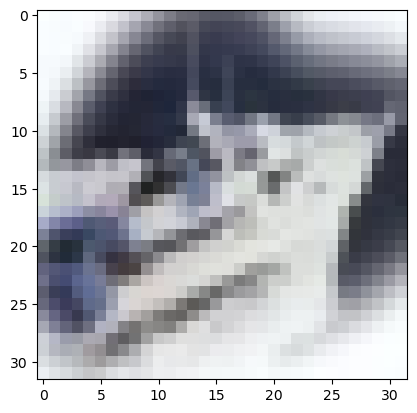

8


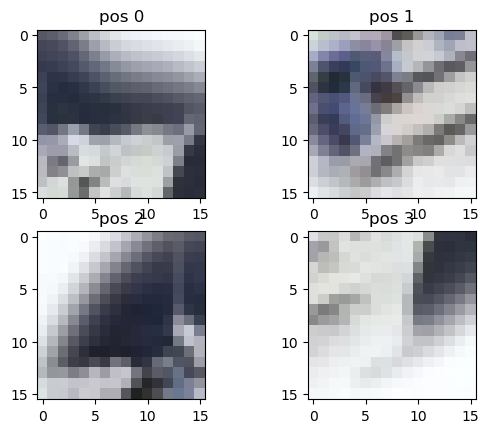

In [4]:
## Show some data
def show():
    def de_transform(data):
        # data = data+0.5
        # data = data*255
        # jt.sync_all()

        return data.numpy().astype(np.uint8)

    ind = np.random.randint(0,new_train_data.shape[0])
    new_data,labels = shuffle_permutation(new_train_data[ind][None],config)
    if old_train_data is not None:

        plt.imshow( de_transform(jt.Var(old_train_data[ind])).transpose(1,2,0))
        plt.show()

    for i in range(4):
        plt.subplot(2,2,i+1,label=f"pos {i}")
        plt.gca().set_title(f"pos {i}")
        # plt.legend()
        plt.imshow(de_transform(new_data[0][i]).transpose(1,2,0))
    print(labels[0])
show()

In [5]:
## Model Define

model = get_model(config)
algo = DPN_Algo(config,model,train_loader,val_loader,test_loader)

## Warm up
summary(model, (4,3,16,16),device="cuda")
logging.info(f"Model: {model.modules()[0]} , Params num: {sum([p.numel() for p in model.parameters()])}")
model.eval()
n= 5
input = new_train_data[0:n]
print(input.shape)
output = model( jt.Var(input)).reshape(-1,4,4)
print(output.shape)
output = sinkhorn(output)
print(output.shape)
target = jt.arange(0,4).repeat(n).reshape(n,4)
print(target.shape)
loss = jt.nn.cross_entropy_loss(output.reshape(-1,4),target.reshape(-1,1))
print(loss.item())
print(input.__class__)
infer = algo.inference(input)
print(infer.shape,infer)
jt.display_memory_info()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
              Conv-1           [-1, 32, 16, 16]             896
        MakeModule-2           [-1, 32, 16, 16]               0
           Dropout-3           [-1, 32, 16, 16]               0
              Pool-4             [-1, 32, 8, 8]               0
              Conv-5             [-1, 64, 8, 8]          18,496
        MakeModule-6             [-1, 64, 8, 8]               0
           Dropout-7             [-1, 64, 8, 8]               0
              Conv-8            [-1, 128, 8, 8]          73,856
        MakeModule-9            [-1, 128, 8, 8]               0
          Dropout-10            [-1, 128, 8, 8]               0
             Pool-11            [-1, 128, 4, 4]               0
             Conv-12            [-1, 256, 4, 4]         295,168
       MakeModule-13            [-1, 256, 4, 4]               0
          Dropout-14            [-1, 25

[i 0521 14:01:28.655039 56 560613846.py:24] 
=== display_memory_info ===
 total_cpu_ram: 62.72GB total_device_ram: 10.91GB
 hold_vars: 67 lived_vars: 86 lived_ops: 18
 name: sfrl is_device: 1 used: 1.496GB(91.1%) unused: 150.1MB(8.92%) total: 1.643GB
 name: sfrl is_device: 1 used:     0 B(0%) unused:   179MB(100%) total:   179MB
 name: sfrl is_device: 0 used:     0 B(0%) unused:   179MB(100%) total:   179MB
 name: sfrl is_device: 0 used:   512 B(0.000273%) unused:   179MB(100%) total:   179MB
 name: temp is_device: 0 used:     0 B(-nan%) unused:     0 B(-nan%) total:     0 B
 name: temp is_device: 1 used:     0 B(0%) unused: 319.8MB(100%) total: 319.8MB
 cpu&gpu: 2.479GB gpu:  2.13GB cpu:   358MB
 free: cpu(3.167GB) gpu(8.435GB)
 swap: total(    0 B) last(    0 B)



[5,4,4,]
[5,4,]
1.3946195840835571
<class 'jittor.jittor_core.Var'>
(5, 4) [[1 3 0 2]
 [1 3 0 2]
 [1 3 0 2]
 [1 3 0 2]
 [1 3 0 2]]


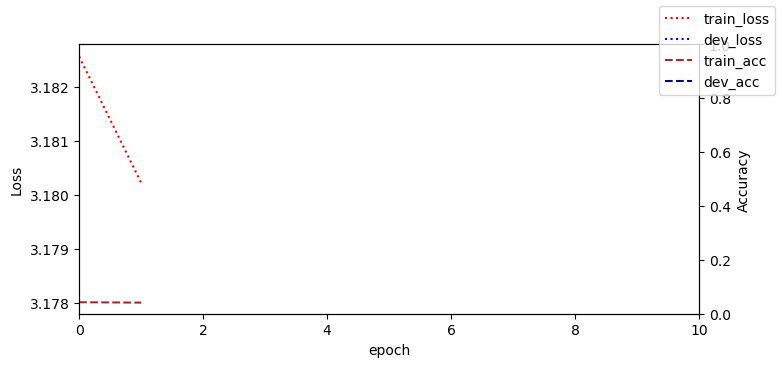

Epoch 1: train_loss 3.180224, train_acc 0.041, dev_loss 3.178024, dev_acc 0.048, 
	 time 19.915 s/epoch, total time 39.829 s, time left 159.318 s


KeyboardInterrupt: 

In [6]:
# Train
algo.train()

In [ ]:
## 这个是用来阻塞进程流的, 该部分以上是训练代码, 该部分以下是测试代码.
raise NotImplementedError

In [ ]:
print(algo.best_acc)

In [ ]:
N = 10
for batch_idx, (data) in enumerate(algo.train_dataloader):
            # data  : [N,4,3,16,16]
    data = data[0]
    X_tilde, label = shuffle_permutation(data,algo.config)
    output = algo.model(X_tilde).reshape(-1,4,4)   # [N,4,4]

    if algo.config["method"]=="classic":
        if algo.config["enable_sinkhorn"]:
            output = sinkhorn(output)              
        loss = algo.criterion(output.reshape(-1,4),jt.Var(label).reshape(-1,1))
        predict = algo._inference(output)          ## predict ,label are numpy array, int
        acc = (np.all(predict == label,axis=1)).sum().item() / len(label)
    elif algo.config["method"]=="relate":
        output = relate(output) #[N,24]
        loss = algo.criterion(output,jt.Var(label).reshape(-1,1))
        predict = algo._inference(output,relate_return_ind=True)          ## predict ,label are numpy array, int
        acc = (predict == label).sum().item() / len(label)

    algo.optimizer.step(loss)
    algo.optimizer.zero_grad()
    print(batch_idx,loss,acc)
    N -=1
    if N==0:
        break

In [ ]:
print(jt.sum(algo.optimizer.param_groups[0]["grads"][0]**2) )

In [ ]:
def test_model(algo):
    def de_transform(data):
        # data = data+0.5
        # data = data*255
        # jt.sync_all()
        return data.numpy().astype(np.uint8)

    ind = np.random.randint(0,new_val_data.shape[0])
    new_data,labels = shuffle_permutation(new_val_data[ind][None],config)
    pred = algo.inference(new_data)
        # pred = algo.inference(new_data,relate_return_ind=True)
    # if old_train_data is not None:

    #     plt.imshow( de_transform(old_train_data[ind]).transpose(1,2,0))
    #     plt.show()

    for i in range(4):
        plt.subplot(2,2,i+1,label=f"pos {i}")
        plt.gca().set_title(f"pos {i}")
        # plt.legend()
        plt.imshow(de_transform(new_data[0][i]).transpose(1,2,0))
    print("True label: ",labels[0])
    if config["method"]=="relate":
        print("Label: ",PERMUTATIONS[labels[0]] )
    print("Predict:    ",pred[0])
    print("Model Output: ",algo.model(new_data).reshape(-1,4,4)[0])
    if config["enable_sinkhorn"]:
        print("Sinkhorn Output: ", sinkhorn(algo.model(new_data).reshape(-1,4,4))[0])
        print("Loss: ", algo.criterion(sinkhorn(algo.model(new_data).reshape(-1,4,4)),jt.Var(labels)))

test_model(algo)


651718_epoch49: 是baseline, 按照标准做法训练的模型, jittor_cel, no sinkhorn, acc 0.865108 

652728_epoch44: jittor_cel, sinkhorn, acc 0.725264

659722_epoch42: relate方法, no sinkhorn, acc 0.909197

In [ ]:
# algo.continue_train(2,config["save_dir"]+"/651718_epoch49")
algo.load(config["save_dir"]+"/675216_epoch6")

In [ ]:
algo.test()